# Detecting Credit Card Fraud Using Bagging and Boosting Techniques

This project aims to build a fraud detection system using ensemble methods. We work with the Credit Card Fraud Detection dataset which consists of 284,807 transactions with 31 features:
- **Time:** Time elapsed (in seconds) since the first transaction.
- **V1 - V28:** Anonymized principal components representing transaction details.
- **Amount:** Transaction amount.
- **Target:** Transaction label (0 for non-fraud, 1 for fraud).

Fraudulent transactions are very rare (≈ 0.17% of the data), so we apply class imbalance handling (using SMOTE) to improve model performance.



In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier


### Loading Dataset


In [3]:

df = pd.read_csv('creditcard.csv')

# Inspect the first few rows of the dataset
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Check for missing values in the dataset.
print("Missing values per column:")
print(df.isnull().sum())



Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [5]:
# Define the features and target variable
X = df.drop('Class', axis=1) 
y = df['Class']

# Splitting dataset into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:


# adressing imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# new class distribution
print("Class distribution after SMOTE:")
print(y_train_res.value_counts())



Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


            Time         V1         V2         V3         V4         V5  \
0       1.159997   1.955041  -0.380783  -0.315013   0.330155  -0.509374   
1       0.618522  -0.400975  -0.626943   1.555339  -2.017772  -0.107769   
2       1.288504   0.072509   0.820566  -0.561351  -0.709897   1.080399   
3       0.132396  -0.535045   1.014587   1.750679   2.769390   0.500089   
4      -0.095434  -4.026938   1.897371  -0.429786  -0.029571  -0.855751   
...          ...        ...        ...        ...        ...        ...   
454897  0.175582 -14.781586  11.171650 -16.038592  10.306626 -11.326882   
454898 -1.546720  -3.909154   3.378800  -2.480032   3.712632  -2.407938   
454899 -1.189244   0.657752   1.647660  -4.071641   3.383953  -1.165887   
454900 -0.092766  -0.911474   2.624404  -3.687345   4.391290  -1.887770   
454901 -1.443587  -1.443001   3.429664  -5.529150   5.333265  -4.387307   

              V6         V7        V8        V9  ...       V20       V21  \
0      -0.086197  -0.62

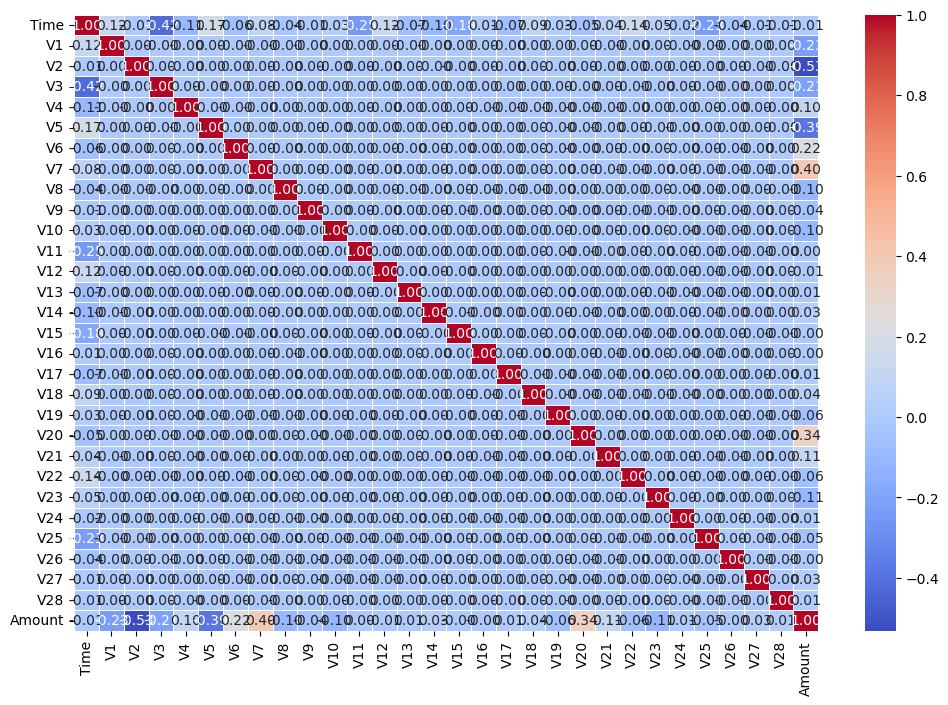

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V20       V21  \
0       0.462388  0.239599  0.098698  0.363787  ...  0.25141

In [7]:

# Feature Scaling
scaler = StandardScaler()

# Fit the scaler on the training data for the 'Amount' and 'Time' columns, then transform both sets
X_train_res[['Amount', 'Time']] = scaler.fit_transform(X_train_res[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])


print(X_train_res)
print(y_train_res)

print(X)
correlation_matrix = X.corr()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#NO HIGH CORRELATION HENCE WE DECIDED TO KEEP ALL THE FEATURES
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Drop the correlated features
X = X.drop(columns=correlated_features)

print(X)

In [10]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

#Classification has been chosen as we are trying to classify if it is a valid transaction or fraudulant

 




In [17]:
print("Gradient Boosting Evaluation:")
print("Accuracy:", accuracy_score(y_test, gbc_pred))
print("Precision:", precision_score(y_test, gbc_pred))
print("Recall:", recall_score(y_test, gbc_pred))
print("F1-Score:", f1_score(y_test, gbc_pred))


gbc_pred_prob = gbc_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (fraud)
threshold = 0.95  # Adjust the threshold
gbc_pred_adjusted = (gbc_pred_prob >= threshold).astype(int)  # Apply threshold

print("Accuracy:", accuracy_score(y_test, gbc_pred_adjusted))
print("Precision after threshold adjustment:", precision_score(y_test, gbc_pred_adjusted))
print("Recall after threshold adjustment:", recall_score(y_test, gbc_pred_adjusted))
print("F1-Score:", f1_score(y_test, gbc_pred_adjusted))


Gradient Boosting Evaluation:
Accuracy: 0.9878164390295284
Precision: 0.11398963730569948
Recall: 0.8979591836734694
F1-Score: 0.20229885057471264
Accuracy: 0.9993153330290369
Precision after threshold adjustment: 0.8470588235294118
Recall after threshold adjustment: 0.7346938775510204
F1-Score: 0.7868852459016393


### Building Models

In [34]:


# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
rf_pred = rf_model.predict(X_test)

print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1-Score:", f1_score(y_test, rf_pred))
print("\n")

# AdaBoost Model 
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_res, y_train_res)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, ada_pred))
print("Precision:", precision_score(y_test, ada_pred))
print("Recall:", recall_score(y_test, ada_pred))
print("F1-Score:", f1_score(y_test, ada_pred))


# GradientBoost
gbc_model = GradientBoostingClassifier(n_estimators=50, # n/5 * 22s is the time consumed for the number of estimators
                                learning_rate=0.05,
                                random_state=42
                                )
gbc_model.fit(X_train_res, y_train_res)
gbc_pred = gbc_model.predict(X_test)

print("Gradient Boosting Evaluation:")
print("Accuracy:", accuracy_score(y_test, gbc_pred))
print("Precision:", precision_score(y_test, gbc_pred))
print("Recall:", recall_score(y_test, gbc_pred))
print("F1-Score:", f1_score(y_test, gbc_pred))
print("\n")

gbc_pred_prob = gbc_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (fraud)
threshold = 0.95  # Adjust the threshold
gbc_pred_adjusted = (gbc_pred_prob >= threshold).astype(int)  # Apply threshold

print("Accuracy:", accuracy_score(y_test, gbc_pred_adjusted))
print("Precision after threshold adjustment:", precision_score(y_test, gbc_pred_adjusted))
print("Recall after threshold adjustment:", recall_score(y_test, gbc_pred_adjusted))
print("F1-Score:", f1_score(y_test, gbc_pred_adjusted))
print("\n")


#XGBoost
xg_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xg_model.fit(X_train_res, y_train_res)
xg_pred = xg_model.predict(X_test)

print("XGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, xg_pred))
print("Precision:", precision_score(y_test, xg_pred))
print("Recall:", recall_score(y_test, xg_pred))
print("F1-Score:", f1_score(y_test, xg_pred))
print("\n")

#Decision Tree
#Could not find away to improve Precision score
dt_model = DecisionTreeClassifier(max_depth=40,min_samples_leaf=15, min_samples_split =35, ccp_alpha=0.01,random_state=42, class_weight='balanced')
dt_model.fit(X_train_res, y_train_res)

dt_pred = dt_model.predict(X_test)
print("Decision Tree Evaluation:")
print("Accuracy:", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred))
print("Recall:", recall_score(y_test, dt_pred))
print("F1-Score:", f1_score(y_test, dt_pred))
print("\n")

Random Forest Evaluation:
Accuracy: 0.9995259997893332
Precision: 0.8736842105263158
Recall: 0.8469387755102041
F1-Score: 0.8601036269430051




/home/campus20/nslange2/.conda/envs/cs-ee5841/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Evaluation:
Accuracy: 0.9866051051578245
Precision: 0.10743801652892562
Recall: 0.9285714285714286
F1-Score: 0.1925925925925926
Gradient Boosting Evaluation:
Accuracy: 0.9878164390295284
Precision: 0.11398963730569948
Recall: 0.8979591836734694
F1-Score: 0.20229885057471264


Accuracy: 0.9993153330290369
Precision after threshold adjustment: 0.8470588235294118
Recall after threshold adjustment: 0.7346938775510204
F1-Score: 0.7868852459016393


XGBoost Evaluation:
Accuracy: 0.999385555282469
Precision: 0.8
Recall: 0.8571428571428571
F1-Score: 0.8275862068965517


Decision Tree Evaluation:
Accuracy: 0.967609985604438
Precision: 0.045761830473218926
Recall: 0.8979591836734694
F1-Score: 0.08708560118753092


